In [1]:
import pandas as pd
#Access the database
import os
import json
wd = os.getcwd()
wd_list = wd.split("/")
unique_path = "/".join(wd_list[1:3])
#I have the passwords file saved as 'nothing_to_see_here.json'. Super secure, I know
path = "/"+unique_path+"/esh/nothing_to_see_here.json"
#Load json file in .esh and get into creds
#This accesses for the db_creds dictionary specifically. Other dicts are available by changing the ref below
creds = json.load(open(path))['db_creds']
from sqlalchemy import create_engine
import os
###DONT SHARE WITH LOGIN DETAILS###
POSTGRES_ADDRESS = creds['esh_db_address']
POSTGRES_PORT =  creds['esh_db_port']
POSTGRES_USERNAME = creds['esh_db_username']
POSTGRES_PASSWORD = creds['esh_db_password']
POSTGRES_DBNAME = creds['esh_db_name']
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,
                password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

In [2]:
query = '''
WITH int_grp AS (
	SELECT hh.state_id,hh.puma20_id, hh.serialno,
     CASE WHEN hh.accessinet::text = '3'::text THEN true ELSE false END AS no_internet,
     CASE WHEN hh.accessinet::text = '1'::text AND hh.hispeed::text = '2'::text AND hh.othsvcex::text = '2'::text AND hh.dialup::text = '2'::text AND hh.satellite::text = '2'::text THEN true
                    ELSE false
                END AS cell_internet_only,
     CASE WHEN hh.accessinet::text = '1'::text AND hh.hispeed::text = '2'::text AND hh.othsvcex::text = '2'::text AND hh.dialup::text = '1'::text AND hh.satellite::text = '2'::text THEN true
                    ELSE false
                END AS dial_up_only,
	pop.povpip as pov_level,
	pop.sporder,
	hh.wgtp as households, 
	pop.pwgtp as population
           FROM dl.pums_households_2022 hh
             LEFT JOIN dl.pums_population_2022 pop ON hh.puma20_id::text = pop.puma20_id::text AND hh.serialno::text = pop.serialno::text
		  )
SELECT state_id, puma20_id, serialno, MAX(households) as households, MIN(pov_level) as pov_level
FROM int_grp
WHERE no_internet = true OR cell_internet_only = true OR dial_up_only = true
GROUP BY state_id, puma20_id, serialno
'''

In [3]:
df = pd.read_sql(query, cnx)
df.shape

(1309869, 5)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

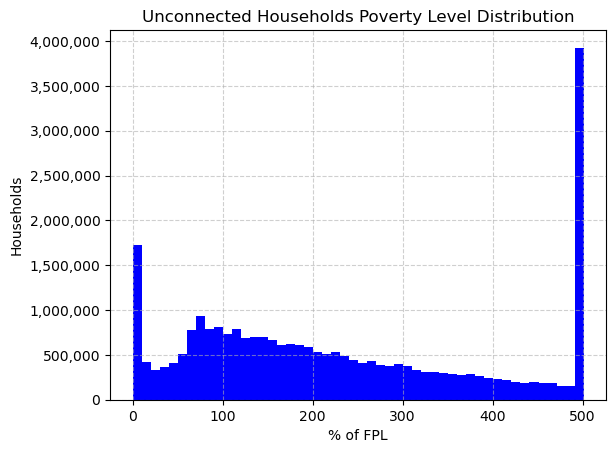

In [5]:
plt.hist(df['pov_level'] 
         ,bins = 50
         ,weights = df['households']
#         ,cumulative = True
         ,color = 'blue'
        )
plt.title('Unconnected Households Poverty Level Distribution')
plt.xlabel('% of FPL')
plt.ylabel('Households')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.grid(True, linestyle='--', alpha=0.6)


plt.show()


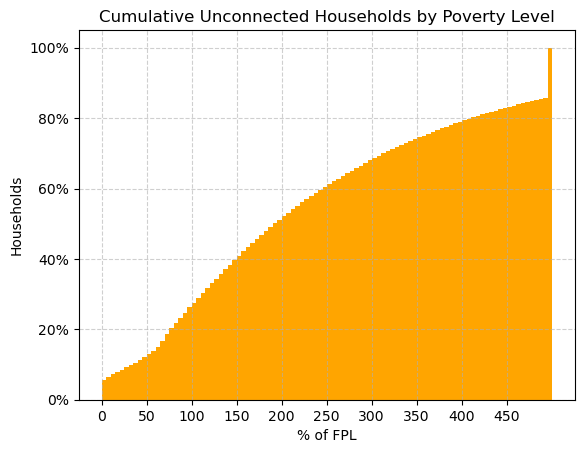

In [36]:
from matplotlib.ticker import PercentFormatter

plt.hist(df['pov_level'] 
         ,bins = 100
         ,weights = df['households']
         ,cumulative = True
         ,color = 'orange'
        )
plt.title('Cumulative Unconnected Households by Poverty Level')
plt.xlabel('% of FPL')
plt.ylabel('Households')
#change y axis to %'s out of the total number of unconnected househlds
total_hh = df['households'].sum()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=total_hh))
plt.yticks(ticks = np.arange(0, total_hh*1.2, total_hh/5),
          labels = ['0%', '20%','40%','60%','80%','100%'])
plt.xticks(ticks = np.arange(0, 500, 50))
plt.grid(True, linestyle='--', alpha=0.6)


plt.show()

In [64]:
u_150 = df[df['pov_level']<=135]
u_150['households'].sum()

9607349.0

In [65]:
total_hh

26911718.0

In [37]:
general_query = '''
    SELECT hh.state_id, hh.puma20_id, hh.serialno,
    MAX(hh.wgtp) as households, MIN(pop.povpip) as pov_level
    FROM dl.pums_households_2022 hh
    LEFT JOIN dl.pums_population_2022 pop ON hh.puma20_id::text = pop.puma20_id::text AND hh.serialno::text = pop.serialno::text
    WHERE pop.povpip is not NULL AND hh.wgtp > 0
    GROUP BY hh.state_id, hh.puma20_id, hh.serialno
'''

In [38]:
gen = pd.read_sql(general_query, cnx)
gen.head()

,state_id,puma20_id,serialno,households,pov_level
0,01,01-0009,2018HU0000071,42.0,501.0
1,01,01-0009,2018HU0000147,9.0,227.0
2,01,01-0009,2018HU0000274,17.0,399.0
3,01,01-0009,2018HU0000285,14.0,151.0
4,01,01-0009,2018HU0000302,10.0,501.0


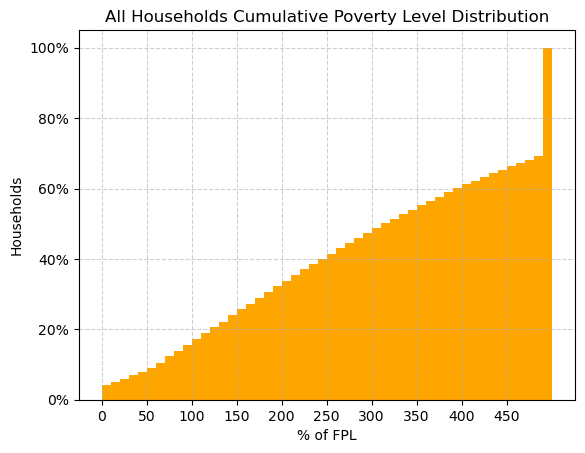

In [43]:
plt.hist(gen['pov_level'] 
         ,bins = 50
         ,weights = gen['households']
         ,cumulative = True
         ,color = 'orange'
        )
plt.title('All Households Cumulative Poverty Level Distribution')
plt.xlabel('% of FPL')
plt.ylabel('Households')

tot = gen['households'].sum()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=tot))
plt.yticks(ticks = np.arange(0, tot*1.2, tot/5),
          labels = ['0%', '20%','40%','60%','80%','100%'])
plt.xticks(ticks = np.arange(0, 500, 50))
plt.grid(True, linestyle='--', alpha=0.6)



plt.show()

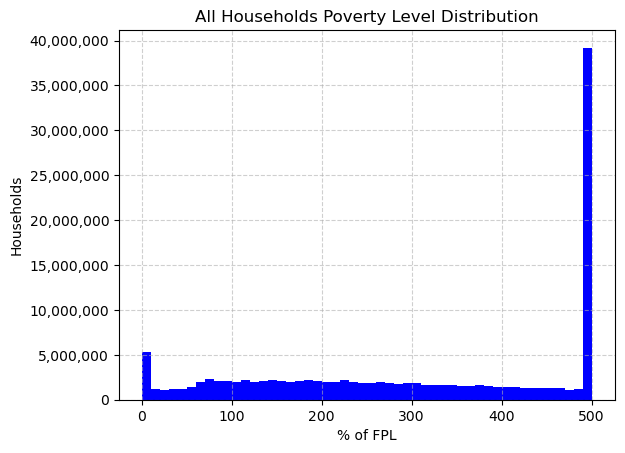

In [42]:
plt.hist(gen['pov_level'] 
         ,bins = 50
         ,weights = gen['households']
#         ,cumulative = True
         ,color = 'blue'
        )
plt.title('All Households Poverty Level Distribution')
plt.xlabel('% of FPL')
plt.ylabel('Households')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.grid(True, linestyle='--', alpha=0.6)


plt.show()

In [48]:
snap_query = '''
SELECT hh.state_id, hh.puma20_id, hh.serialno,
    MAX(hh.wgtp) as households, MIN(pop.povpip) as pov_level
FROM dl.pums_households_2022 hh
LEFT JOIN dl.pums_population_2022 pop ON hh.puma20_id::text = pop.puma20_id::text AND hh.serialno::text = pop.serialno::text
WHERE hh.fs = '1' and pop.povpip is not NULL and hh.wgtp>0
GROUP BY hh.state_id, hh.puma20_id, hh.serialno
'''

In [49]:
sn = pd.read_sql(snap_query, cnx)
sn.head()

,state_id,puma20_id,serialno,households,pov_level
0,01,01-0009,2018HU0000147,9.0,227.0
1,01,01-0009,2018HU0000472,35.0,264.0
2,01,01-0009,2018HU0000525,7.0,144.0
3,01,01-0009,2018HU0000969,12.0,45.0
4,01,01-0009,2018HU0001042,3.0,67.0


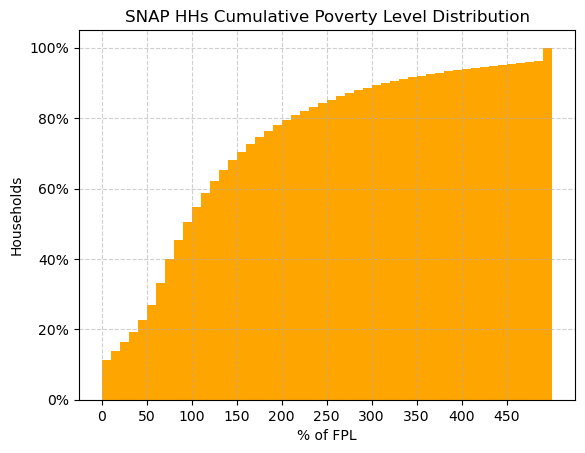

In [51]:
plt.hist(sn['pov_level'] 
         ,bins = 50
         ,weights = sn['households']
         ,cumulative = True
         ,color = 'orange'
        )
plt.title('SNAP HHs Cumulative Poverty Level Distribution')
plt.xlabel('% of FPL')
plt.ylabel('Households')

tot = sn['households'].sum()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=tot))
plt.yticks(ticks = np.arange(0, tot*1.2, tot/5),
          labels = ['0%', '20%','40%','60%','80%','100%'])
plt.xticks(ticks = np.arange(0, 500, 50))
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

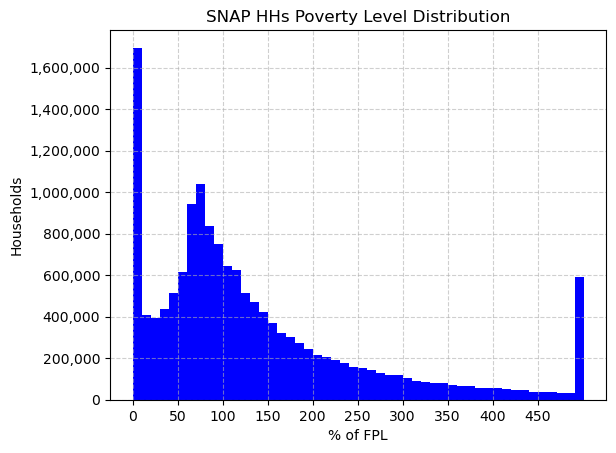

In [54]:
plt.hist(sn['pov_level'] 
         ,bins = 50
         ,weights = sn['households']
#         ,cumulative = True
         ,color = 'blue'
        )
plt.title('SNAP HHs Poverty Level Distribution')
plt.xlabel('% of FPL')
plt.ylabel('Households')

#tot = sn['households'].sum()
#plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=tot))
#plt.yticks(ticks = np.arange(0, tot*1.2, tot/5),
#          labels = ['0%', '20%','40%','60%','80%','100%'])
plt.xticks(ticks = np.arange(0, 500, 50))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [58]:
medicaid_query = '''
SELECT hh.state_id, hh.puma20_id, hh.serialno,
    MAX(hh.wgtp) as households, MIN(pop.povpip) as pov_level
FROM dl.pums_households_2022 hh
LEFT JOIN dl.pums_population_2022 pop ON hh.puma20_id::text = pop.puma20_id::text AND hh.serialno::text = pop.serialno::text
WHERE pop.hins4 = '1' and pop.povpip is not NULL and hh.wgtp>0
GROUP BY hh.state_id, hh.puma20_id, hh.serialno
'''

In [59]:
md = pd.read_sql(medicaid_query, cnx)
md.shape

(1430023, 5)

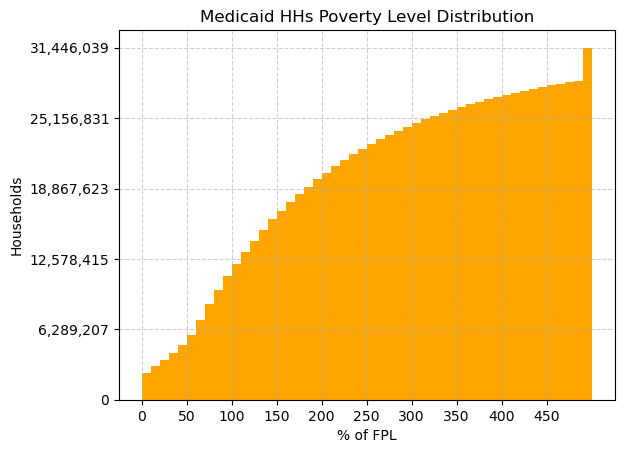

In [61]:
plt.hist(md['pov_level'] 
         ,bins = 50
         ,weights = md['households']
         ,cumulative = True
         ,color = 'orange'
        )
plt.title('Medicaid HHs Poverty Level Distribution')
plt.xlabel('% of FPL')
plt.ylabel('Households')

tot = md['households'].sum()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=tot))
plt.yticks(ticks = np.arange(0, tot*1.2, tot/5),
          labels = ['0%', '20%','40%','60%','80%','100%'])
plt.xticks(ticks = np.arange(0, 500, 50))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()